# imports and reading data

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import torch.optim as optim
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 5)
import pickle

In [2]:
vocab = open('20news-bydate/vocabulary.txt', 'r').read().split()
Y_train_valid = np.array(list(map(int, open('20news-bydate/matlab/train.label', 'r').read().split()))) - 1
Y_test = np.array(list(map(int, open('20news-bydate/matlab/test.label', 'r').read().split()))) - 1
m_train_valid = len(Y_train_valid)
m_test = len(Y_test)
LEN_VOCAB = len(vocab)

In [3]:
X_train_valid = np.zeros((m_train_valid, LEN_VOCAB))
X_test = np.zeros((m_test, LEN_VOCAB))

In [4]:
with open('20news-bydate/matlab/train.data', "r") as ins:
    for line in ins:
        i, j, k = map(int, line.split())
        X_train_valid[i - 1, j - 1] = k
with open('20news-bydate/matlab/test.data', "r") as ins:
    for line in ins:
        i, j, k = map(int, line.split())
        X_test[i - 1, j - 1] = k

In [5]:
def split_train_valid():
    perm = np.random.permutation(m_train_valid)
    X_train = X_train_valid[perm[:int(4*len(perm)/5)]]
    X_valid = X_train_valid[perm[int(4*len(perm)/5):]]
    Y_train = Y_train_valid[perm[:int(4*len(perm)/5)]]
    Y_valid = Y_train_valid[perm[int(4*len(perm)/5):]]
    m_train = int(4*len(perm)/5)
    m_valid = m_train_valid - m_train
    return X_train, X_valid, Y_train, Y_valid, m_train, m_valid

In [6]:
X_train, X_valid, Y_train, Y_valid, m_train, m_valid = split_train_valid()

In [7]:
data = {'X_train': X_train,
        'X_valid': X_valid,
        'X_test': X_test,
        'Y_train': Y_train,
        'Y_valid': Y_valid,
        'Y_test': Y_test}

## Create the model and useful functions

In [8]:
class Net(nn.Module):
    def __init__(self, input_size=LEN_VOCAB, output_size=20, hidden_layer_size=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size, bias=True)
        self.fc2 = nn.Linear(hidden_layer_size, output_size, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def random_mini_batches_idx(m, mini_batch_size = 64):
    permutation = np.random.permutation(m)
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    list_of_indices = []
    for k in range(0, num_complete_minibatches):
        list_of_indices.append(list(permutation[k * mini_batch_size: k * mini_batch_size + mini_batch_size]))
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        list_of_indices.append(list(permutation[num_complete_minibatches * mini_batch_size : m]))
    return list_of_indices

In [10]:
def get_accuracy(net, X, Y):
    minibatches_indices = random_mini_batches_idx(X.shape[0], mini_batch_size=100)
    total_correct = 0
    total_examples = 0
    for i, indices in enumerate(minibatches_indices):
        inputs = X[indices]
        labels = Y[indices]
        inputs = torch.from_numpy(inputs).float()
        true_labels = torch.from_numpy(labels).long()
        if torch.cuda.is_available():
            inputs, true_labels = inputs.cuda(), true_labels.cuda()
        inputs, labels = Variable(inputs), Variable(true_labels)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == true_labels).sum()
        total_examples += len(indices)
    return float(total_correct)/total_examples

In [11]:
def train(data = data,
          lr=0.005, momentum=0.9, weight_decay=0,
          n_epochs=20, net=None,
          print_stuff=True, mini_batch_size = 64,
          get_loss=False, stop_at=5000,
          print_every=50):
    if net is None:
        net = Net()
    X_train, X_valid, X_test = data['X_train'], data['X_valid'], data['X_test']
    Y_train, Y_valid, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    if print_stuff:
        print(net)
    if torch.cuda.is_available():
        if(print_stuff):
            print("Using CUDA")
        net = net.cuda()
    #---useful only for loss at each iteration---
    if get_loss:
        losses = []
        allinputs = torch.from_numpy(X_train).float()
        alllabels = torch.from_numpy(Y_train).long()
        if torch.cuda.is_available():
            allinputs, alllabels = allinputs.cuda(), alllabels.cuda()
        allinputs, alllabels = Variable(allinputs), Variable(alllabels)
        print('evaluating loss')
        alloutputs = net(allinputs)
        loss = criterion(alloutputs, alllabels, )
        losses = [loss.data[0]]
        print('losses = {0}'.format(losses))
    #----------------------------------------------

    acc_train = get_accuracy(net, X_train, Y_train)
    acc_valid = get_accuracy(net, X_valid, Y_valid)
    acc_test = get_accuracy(net, X_test, Y_test)
    accuracies_train = [acc_train]
    accuracies_valid = [acc_valid]
    accuracies_test = [acc_test]

    if print_stuff:
        print("Accuracy on training set: {0}".format(acc_train))
        print("Accuracy on validation set: {0}".format(acc_valid))
        print("Accuracy on test set: {0}".format(acc_test))

    for epoch in range(n_epochs): 
        broken = 0
        minibatches_indices = random_mini_batches_idx(X_train.shape[0], mini_batch_size=mini_batch_size)
        running_loss = 0.0
        total_correct = 0
        total_examples = 0
        for i, indices in enumerate(minibatches_indices):
            inputs = X_train[indices]
            labels = Y_train[indices]
            inputs = torch.from_numpy(inputs).float()
            true_labels = torch.from_numpy(labels).long()
            if torch.cuda.is_available():
                inputs, true_labels = inputs.cuda(), true_labels.cuda()
            inputs, labels = Variable(inputs), Variable(true_labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data[0]
            #---useful only for loss at each iteration---
            if get_loss:
                alloutputs = net(allinputs)
                lossall = criterion(alloutputs, alllabels)
                losses.append(lossall.data[0])
                if len(losses) >= stop_at:
                    broken = 1
                    break
                if i % print_every == print_every - 1:  
                    if print_stuff:
                        print('losses = {0}'.format(losses[-10:]))
            #----------------------------------------------
            if print_stuff and i % print_every == print_every - 1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.7f' % (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
        if broken:
            break
        acc_train = get_accuracy(net, X_train, Y_train)
        acc_valid = get_accuracy(net, X_valid, Y_valid)
        acc_test = get_accuracy(net, X_test, Y_test)
        if print_stuff:
            print ("Epoch {0}".format(epoch + 1))
            print ("Accuracy on training set: {0}".format(acc_train))
            print ("Accuracy on validation set: {0}".format(acc_valid))
            print ("Accuracy on test set: {0}".format(acc_test))
            print ('')
        accuracies_train.append(acc_train)
        accuracies_valid.append(acc_valid)
        accuracies_test.append(acc_test)
    if print_stuff:
        print('Finished Training')
    toreturn = {'net': net,
                'accuracies_train': accuracies_train,
                'accuracies_valid': accuracies_valid,
                'accuracies_test': accuracies_test}
    if get_loss:
        toreturn['losses'] = losses
    return toreturn

## hyperparam search

In [8]:
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

In [ ]:
last_validation_accuracies = []
all_accuracies = []
for l, lr in enumerate(lrs):
    print("Learning rate {}/{}: {:.2e}".format(l + 1, len(lrs), lr))
    returned = train(data=data, lr=lr, print_stuff=False)
    print("Accuracies (train, valid, test) : ({:.2f}, {:.2f}, {:.2f})".format(100 * returned['accuracies_train'][-1], 100 * returned['accuracies_valid'][-1], 100 * returned['accuracies_test'][-1]))
    last_validation_accuracies.append(returned['accuracies_valid'][-1])
    all_accuracies.append(returned)

In [48]:
#pickle.dump([{k: v for k, v in dic.items() if k !='net'} for dic in all_accuracies],
#              open('hpsearch_nopre_nopandas.pkl', 'wb'))

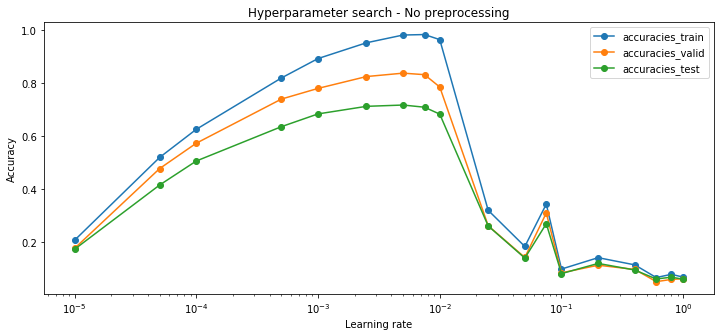

In [59]:
all_accuracies = pickle.load(open('hpsearch_nopre_nopandas.pkl', 'rb'))
last_accuracies = list(map(lambda dic: {k: v[-1] for k, v in dic.items()}, all_accuracies))
last_accuracies = dict(zip(last_accuracies[0],zip(*[d.values() for d in last_accuracies])))
for k, v in last_accuracies.items():
    plt.semilogx(lrs, v, '-o', label=k)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Hyperparameter search - No preprocessing")
plt.legend()
plt.show()

In [61]:
last_validation_accuracies = list(map(lambda dic: dic['accuracies_valid'][-1], all_accuracies))

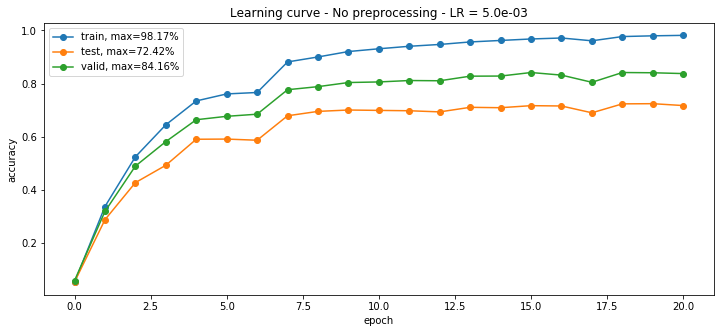

In [63]:
accuracies_train = all_accuracies[np.argmax(last_validation_accuracies)]['accuracies_train']
accuracies_valid = all_accuracies[np.argmax(last_validation_accuracies)]['accuracies_valid']
accuracies_test = all_accuracies[np.argmax(last_validation_accuracies)]['accuracies_test']
plt.plot(accuracies_train, '-o', label='train, max={:.2f}%'.format(100 * max(accuracies_train)))
plt.plot(accuracies_test, '-o', label='test, max={:.2f}%'.format(100 * max(accuracies_test)))
plt.plot(accuracies_valid, '-o', label='valid, max={:.2f}%'.format(100 * max(accuracies_valid)))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Learning curve - No preprocessing - LR = {:.1e}".format(lrs[np.argmax(last_validation_accuracies)]))
plt.legend()
plt.show()

# Preprocessing

## tf-idf

In [9]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
X_train_tfidf = np.squeeze(np.asarray(X_train_tfidf.todense()))
X_valid_tfidf = np.squeeze(np.asarray(X_valid_tfidf.todense()))
X_test_tfidf = np.squeeze(np.asarray(X_test_tfidf.todense()))

In [15]:
data_tfidf = {'X_train': X_train_tfidf,
             'X_valid': X_valid_tfidf,
             'X_test': X_test_tfidf,
             'Y_train': Y_train,
             'Y_valid': Y_valid,
             'Y_test': Y_test}

In [ ]:
last_tfidf_validation_accuracies = []
all_tfidf_accuracies = []
for l, lr in enumerate(lrs):
    print("Learning rate {}/{}: {:.2e}".format(l + 1, len(lrs), lr))
    returned = train(data=data_tfidf, lr=lr, print_stuff=False)
    print("Accuracies (train, valid, test) : ({:.2f}, {:.2f}, {:.2f})".format(100 * returned['accuracies_train'][-1], 100 * returned['accuracies_valid'][-1], 100 * returned['accuracies_test'][-1]))
    last_tfidf_validation_accuracies.append(returned['accuracies_valid'][-1])
    all_tfidf_accuracies.append(returned)

In [42]:
#pickle.dump([{k: v for k, v in dic.items() if k !='net'} for dic in all_tfidf_accuracies], open('hpsearch_tfidf_nopandas.pkl', 'wb'))

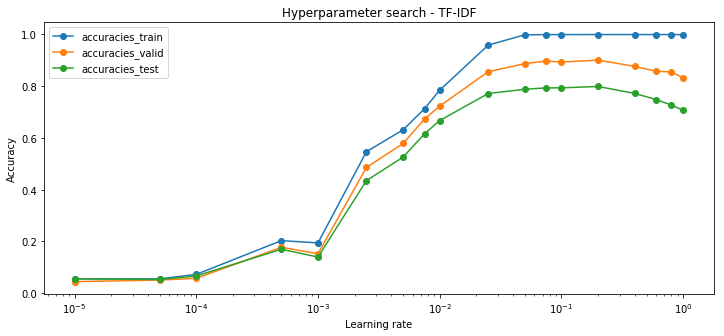

In [65]:
all_tfidf_accuracies = pickle.load(open('hpsearch_tfidf_nopandas.pkl', 'rb'))
last_tfidf_accuracies = list(map(lambda dic: {k: v[-1] for k, v in dic.items()}, all_tfidf_accuracies))
last_tfidf_accuracies = dict(zip(last_tfidf_accuracies[0],zip(*[d.values() for d in last_tfidf_accuracies])))
for k, v in last_tfidf_accuracies.items():
    plt.semilogx(lrs, v, '-o', label=k)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Hyperparameter search - TF-IDF")
plt.legend()
plt.show()

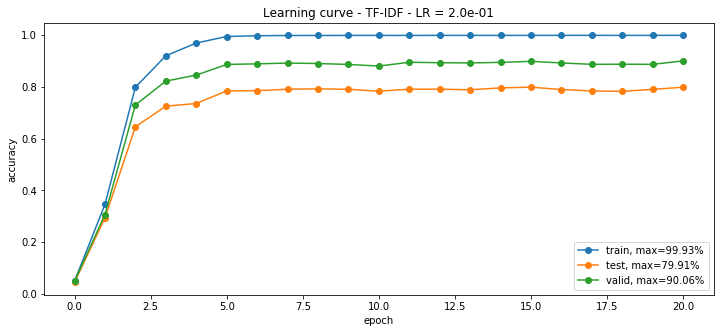

In [70]:
last_tfidf_validation_accuracies = list(map(lambda dic: dic['accuracies_valid'][-1], all_tfidf_accuracies))
accuracies_train = all_tfidf_accuracies[np.argmax(list(last_tfidf_validation_accuracies))]['accuracies_train']
accuracies_valid = all_tfidf_accuracies[np.argmax(list(last_tfidf_validation_accuracies))]['accuracies_valid']
accuracies_test = all_tfidf_accuracies[np.argmax(list(last_tfidf_validation_accuracies))]['accuracies_test']
plt.plot(accuracies_train, '-o', label='train, max={:.2f}%'.format(100 * max(accuracies_train)))
plt.plot(accuracies_test, '-o', label='test, max={:.2f}%'.format(100 * max(accuracies_test)))
plt.plot(accuracies_valid, '-o', label='valid, max={:.2f}%'.format(100 * max(accuracies_valid)))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Learning curve - TF-IDF - LR = {:.1e}".format(lrs[np.argmax(last_tfidf_validation_accuracies)]))
plt.legend()
plt.show()

## standaridization

In [11]:
means = np.mean(X_train, axis=0)

In [12]:
stds = np.std(X_train, axis=0)

In [13]:
epsilon = 1e-5

In [14]:
X_train_stan = (X_train - means) / (stds + epsilon)

In [17]:
X_valid_stan = (X_valid - means) / (stds + epsilon)

In [18]:
X_test_stan = (X_test - means) / (stds + epsilon)

In [36]:
data_stan = {'X_train': X_train_stan,
             'X_valid': X_valid_stan,
             'X_test': X_test_stan,
             'Y_train': Y_train,
             'Y_valid': Y_valid,
             'Y_test': Y_test}

In [ ]:
last_stan_validation_accuracies = []
all_stan_accuracies = []
for l, lr in enumerate(lrs):
    print("Learning rate {}/{}: {:.2e}".format(l + 1, len(lrs), lr))
    returned = train(data=data_stan, lr=lr, print_stuff=False)
    print("Accuracies (train, valid, test) : ({:.2f}, {:.2f}, {:.2f})".format(100 * returned['accuracies_train'][-1], 100 * returned['accuracies_valid'][-1], 100 * returned['accuracies_test'][-1]))
    last_stan_validation_accuracies.append(returned['accuracies_valid'][-1])
    all_stan_accuracies.append(returned)

In [42]:
#pickle.dump([{k: v for k, v in dic.items() if k !='net'} for dic in all_stan_accuracies],
#            open('hpsearch_stan_nopandas.pkl', 'wb'))

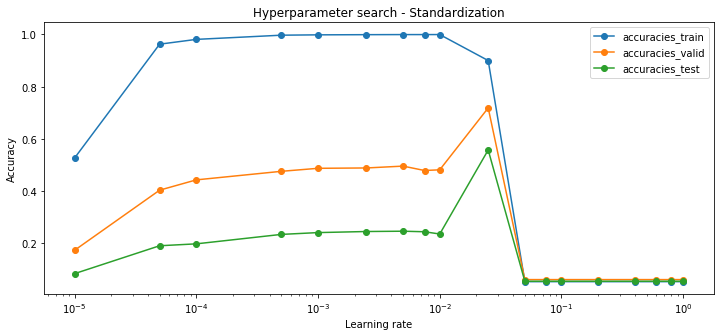

In [67]:
all_stan_accuracies = pickle.load(open('hpsearch_stan_nopandas.pkl', 'rb'))
last_stan_accuracies = list(map(lambda dic: {k: v[-1] for k, v in dic.items()}, all_stan_accuracies))
last_stan_accuracies = dict(zip(last_stan_accuracies[0],zip(*[d.values() for d in last_stan_accuracies])))
for k, v in last_stan_accuracies.items():
    plt.semilogx(lrs, v, '-o', label=k)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Hyperparameter search - Standardization")
plt.legend()
plt.show()

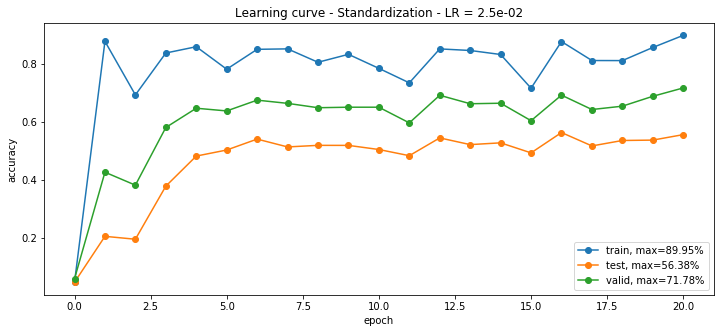

In [69]:
last_stan_validation_accuracies = list(map(lambda dic: dic['accuracies_valid'][-1], all_stan_accuracies))
accuracies_train = all_stan_accuracies[np.argmax(list(last_stan_validation_accuracies))]['accuracies_train']
accuracies_valid = all_stan_accuracies[np.argmax(list(last_stan_validation_accuracies))]['accuracies_valid']
accuracies_test = all_stan_accuracies[np.argmax(list(last_stan_validation_accuracies))]['accuracies_test']
plt.plot(accuracies_train, '-o', label='train, max={:.2f}%'.format(100 * max(accuracies_train)))
plt.plot(accuracies_test, '-o', label='test, max={:.2f}%'.format(100 * max(accuracies_test)))
plt.plot(accuracies_valid, '-o', label='valid, max={:.2f}%'.format(100 * max(accuracies_valid)))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Learning curve - Standardization - LR = {:.1e}".format(lrs[np.argmax(last_stan_validation_accuracies)]))
plt.legend()
plt.show()

## plotting losses

In [ ]:
returned_tfidf = train(data=data_tfidf, lr=0.2, momentum=0, mini_batch_size=1, get_loss=True, print_every=200)

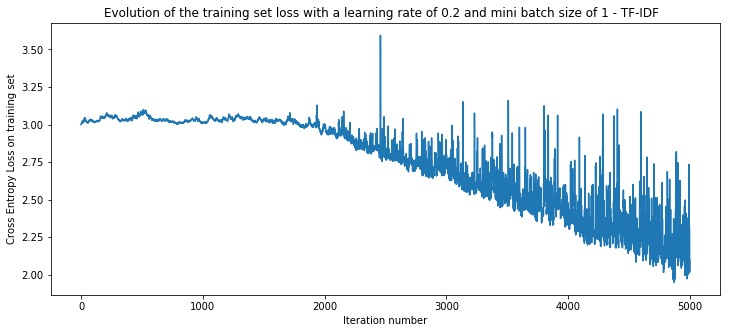

In [32]:
#losses = returned_tfidf['losses']
#pickle.dump(losses, open('losses_minibtch1.pkl', 'wb'))
losses = pickle.load(open('losses_minibtch1.pkl', 'wb'))
plt.plot(losses, '-')
plt.xlabel('Iteration number')
plt.ylabel('Cross Entropy Loss on training set')
plt.title('Evolution of the training set loss with a learning rate of 0.2 and mini batch size of 1 - TF-IDF  ')
plt.show()

In [ ]:
returned_tfidf = train(data=data_tfidf, lr=0.2, momentum=0, n_epochs=60, mini_batch_size=100, get_loss=True, print_every=40)

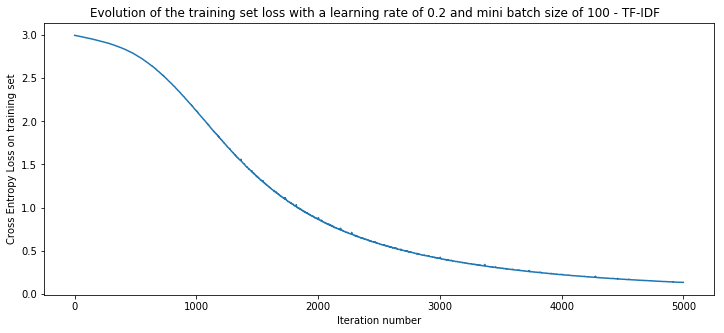

In [22]:
#losses = returned_tfidf['losses']
#pickle.dump(losses, open('losses_minibtch100.pkl', 'wb'))
losses = pickle.load(open('losses_minibtch100.pkl', 'rb'))
plt.plot(losses, '-')
plt.xlabel('Iteration number')
plt.ylabel('Cross Entropy Loss on training set')
plt.title('Evolution of the training set loss with a learning rate of 0.2 and mini batch size of 100 - TF-IDF  ')
plt.show()

# Explain the generalization gap

In [27]:
colsums = X_train.sum(axis=0)

In [28]:
words_non_existing_in_train = [i for i in range(LEN_VOCAB) if colsums[i]==0]

In [71]:
print(LEN_VOCAB)

61188


In [29]:
print(len(words_non_existing_in_train))

10489

In [33]:
colsums_test = X_test.sum(axis=0)
colsums_valid = X_valid.sum(axis=0)
words_in_valid_but_not_in_train = [i for i in words_non_existing_in_train if colsums_valid[i] != 0]
words_in_test_but_not_in_train = [i for i in words_non_existing_in_train if colsums_test[i] != 0]

In [32]:
print(len(words_in_valid_but_not_in_train))

3276

In [37]:
print(len(words_in_test_but_not_in_train))

9545
